# CellNet

In [1]:
IMAGES = 'one'; AUGS = 'val'
P = 'sigma'; ps = [4]#[1, 2, 3, 4, 5, 6, 7, 8, 9]


import ast
from math import prod
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

import albumentations as A
from albumentations.pytorch import ToTensorV2

from types import SimpleNamespace as obj

import util.data as data
import util.plot as plot


CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu'); print('device =', device)
DRAFT = False if os.getenv('BATCHED_RUN', '0')=='1' else True; print('DRAFT =', DRAFT)

def gpu(x, device=device): return torch.from_numpy(x).float().to(device)
def cpu(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

key2text = {'tl': 'Training Loss',     'vl': 'Validation Loss', 
            'ta': 'Training Accuracy', 'va': 'Validation Accuracy', 
            'ti': 'Training Image',    'vi': 'Validation Image',
            'lf': 'Loss Function',     'lr': 'Learning Rate',
            'e' : 'Epoch',             'bs': 'Batch Size',
            'fraction': 'Fraction of Data',  'sparsity': 'Artificial Sparsity',  
            'sigma': 'Gaussian Sigma',        'maxdist': 'Max Distance',
            }

CROPSIZE=256

device = cuda:0
DRAFT = False


In [2]:
XNorm = data.mk_XNorm([1,2,4])

def mkAugs(mode):
  T = lambda ts:  A.Compose(transforms=[
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    *ts,
    XNorm(), 
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True) # type: ignore
  )

  vals = [A.D4(),
          ]

  return dict(
    test  = T([]),
    val   = T([A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
               *vals]),
    train = T([
               A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
              #A.RandomSizedCrop(p=1, min_max_height=(CROPSIZE//2, CROPSIZE*2), height=CROPSIZE, width=CROPSIZE),
              # NOTE: issue with resize is that the keypoint sizes will not be updated
               A.Rotate(),
               A.AdvancedBlur(),
               A.Equalize(),
               A.ColorJitter(), 
               A.GaussNoise(),
               *vals])
  )[mode]

In [3]:

def plot_overlay(x,m,z,k,l, ax=None, sigma=5):
  ax = plot.image(x, ax=ax)
  plot.heatmap(1-m, ax=ax, alpha=lambda x: 0.5*x, color='#000000')
  plot.heatmap(  z, ax=ax, alpha=lambda x: 1.0*x, color='#ff0000')
  plot.points(ax, k, sigma, l)
  return ax

def plot_diff(x,m,y,z,k,l, ax=None, sigma=5):
  title = f"Difference between Target and Predicted Heatmap"
  D = y-z; D[0, 1,0] = -1; D[0, 1,1] = 1 
  ax = plot.image(D, ax=ax, cmap='coolwarm')
  plot.heatmap(1-m, ax=ax, alpha=lambda x: 0.2*x, color='#000000')
  plot.points(ax, k, sigma, l)
  return ax


if DRAFT and not CUDA: 
  _cfg = obj(sigma=3.5, maxdist=26, fraction=1, sparsity=1)
  keypoints2heatmap, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], _cfg)

  def plot_grid(grid, **loader_kwargs):
    loader = data.mk_loader([1], cfg=_cfg, bs=prod(grid), **loader_kwargs)
    B = next(iter(loader))
    B = zip(B['image'], B['masks'][0], keypoints2heatmap(B), B['keypoints'], B['class_labels'])
    for b,ax in zip(B, plot.grid(grid, [CROPSIZE]*2)[1]):
      plot_overlay(*[cpu(v) for v in b], ax=ax)

  for B in data.mk_loader([1,2,4], cfg=_cfg, bs=1, transforms=mkAugs('test'), shuffle=False):
    ax = plot_overlay(*[cpu(v[0]) for v in [B['image'], B['masks'][0], keypoints2heatmap(B), B['keypoints'], B['class_labels']]])

  plot_grid((3,3), transforms=mkAugs('val'))
  plot_grid((3,3), transforms=mkAugs('train'))

In [4]:
import segmentation_models_pytorch as smp
plt.close('all')

mk_model = lambda: smp.Unet(  # NOTE TODO: check if spefically used model automatically mirror pads in training or inference
    encoder_name="resnet34" if DRAFT else "resnet152",  # 18 34 50 101 152
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
  ).to(device)  

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


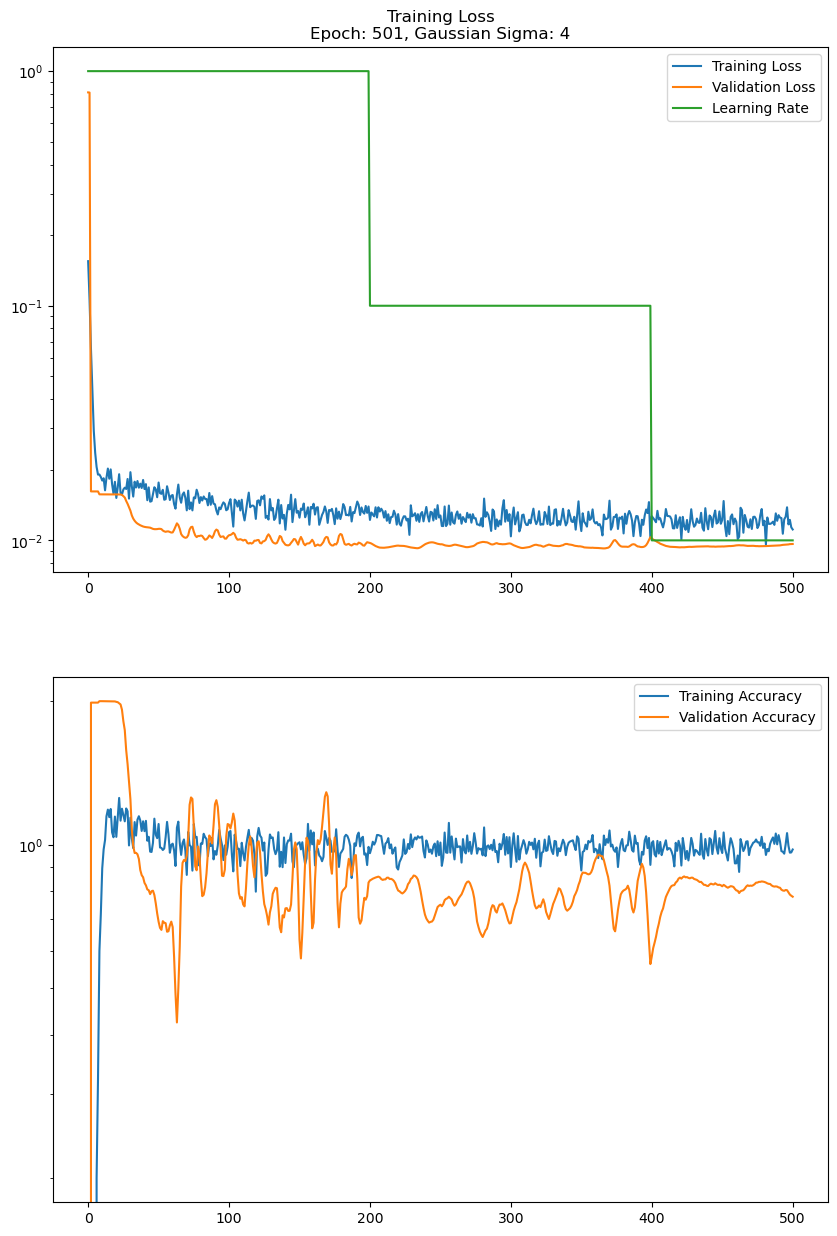

/gpfs/space/home/eckhardt/sanger/results/cellnet/240528-111224-valaugs-1-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


In [5]:

#def count(y): return yunnorm(y).sum().item()

def accuracy(y,z): 
  ny, nz = y.sum().item(), z.sum().item()
  return 1 - (ny - nz) / nz

def train(epochs, model, optim, lossf, sched, kp2hm, traindl, valdl=None, info={}):
  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(epochs))
  def epoch(dl, train):
    l = 0; a = 0; b = 0
    for b, B in enumerate(dl):
      x,m = B['image'].to(device), B['masks'][0].to(device)
      z = kp2hm(B).to(device)

      y = model(x)
      loss = lossf(y*m, z*m) 
      l += loss.item()
      a += accuracy(y*m, z*m) # type: ignore

      if train:
        loss.backward()
        optim.step()
        optim.zero_grad()

    return l/(b+1), a/(b+1)

  for e in range(epochs):
    L = log.loc[e]
    L['lr'] = optim.param_groups[0]['lr']
  
    model.train()
    L['tl'], L['ta'] = epoch(traindl, train=True)
    sched.step() 
  
    if valdl is not None: 
      model.eval()
      with torch.no_grad():
        L['vl'], L['va'] = epoch(valdl, train=False) 

    if DRAFT: plot.train_graph(e, log, info=info, key2text=key2text, clear=True)
  plot.train_graph(epochs, log, info=info, key2text=key2text) 
  return log


splits = [([1], [2])] if DRAFT else dict(
  one = [([1], [2,4])],
  all = [([2,4], [1]), ([1,4], [2]), ([1,2], [4])],
)[IMAGES]

results = pd.DataFrame()
[os.makedirs(p, exist_ok=True) for p in ('preds', 'plots')]
for p in [1] if DRAFT else ps:
  for ti, vi in splits:
    cfg = obj(**(dict(
      sigma=3.5, 
      maxdist=26, 
      fraction=1, 
      sparsity=1)
      | {P: p}))
    loader = lambda ids, mode: data.mk_loader(ids, bs=1 if mode=='test' else 16, transforms=mkAugs(mode), shuffle=False, cfg=cfg)
    traindl, valdl = loader(ti, AUGS), loader(vi, 'val' if AUGS=='train' else 'test')
    
    kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg)

    model = mk_model()
    optim = torch.optim.Adam(model.parameters(), lr=5e-3)
    lossf = torch.nn.MSELoss()
    sched = torch.optim.lr_scheduler.StepLR(optim, step_size=200, gamma=0.1)

    log = train((5 if CUDA else 1) if DRAFT else 501, model, optim, lossf, sched, kp2hm, traindl, valdl, info={P: p})

    _row =  pd.DataFrame(dict(**{P: [p]}, ti=[ti], vi=[vi], **log.iloc[-1]))
    results = _row if results.empty else pd.concat([results, _row], ignore_index=True)

    # save predictions to disk
    for ii, t in [(ti, 'T'), (vi, 'V')]:
      for i in ii:
        B = next(iter(data.mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))
        x,m,z,k,l = [cpu(v[0]) for v in [B['image'], B['masks'][0], kp2hm(B), B['keypoints'], B['class_labels']]]

        model.eval()
        with torch.no_grad(): y = cpu(model(B['image'].to(device)))[0]

        id = f"{P}={p}-{t}{i}"
        #np.save(f'preds/{id}.npy', y)
        ax = plot_overlay(x,m,y,k,l, sigma=cfg.sigma); plot.save(ax, f'plots/{id}.pred.png')
        ax = plot_diff (x,m,y,z,k,l, sigma=cfg.sigma); plot.save(ax, f'plots/{id}.diff.png')
        if not DRAFT: plt.close('all')

,sigma,ti,vi,tl,vl,ta,va,lr
0,4,[1],"[2, 4]",0.011129,0.009651,0.97748,0.778422,0.01


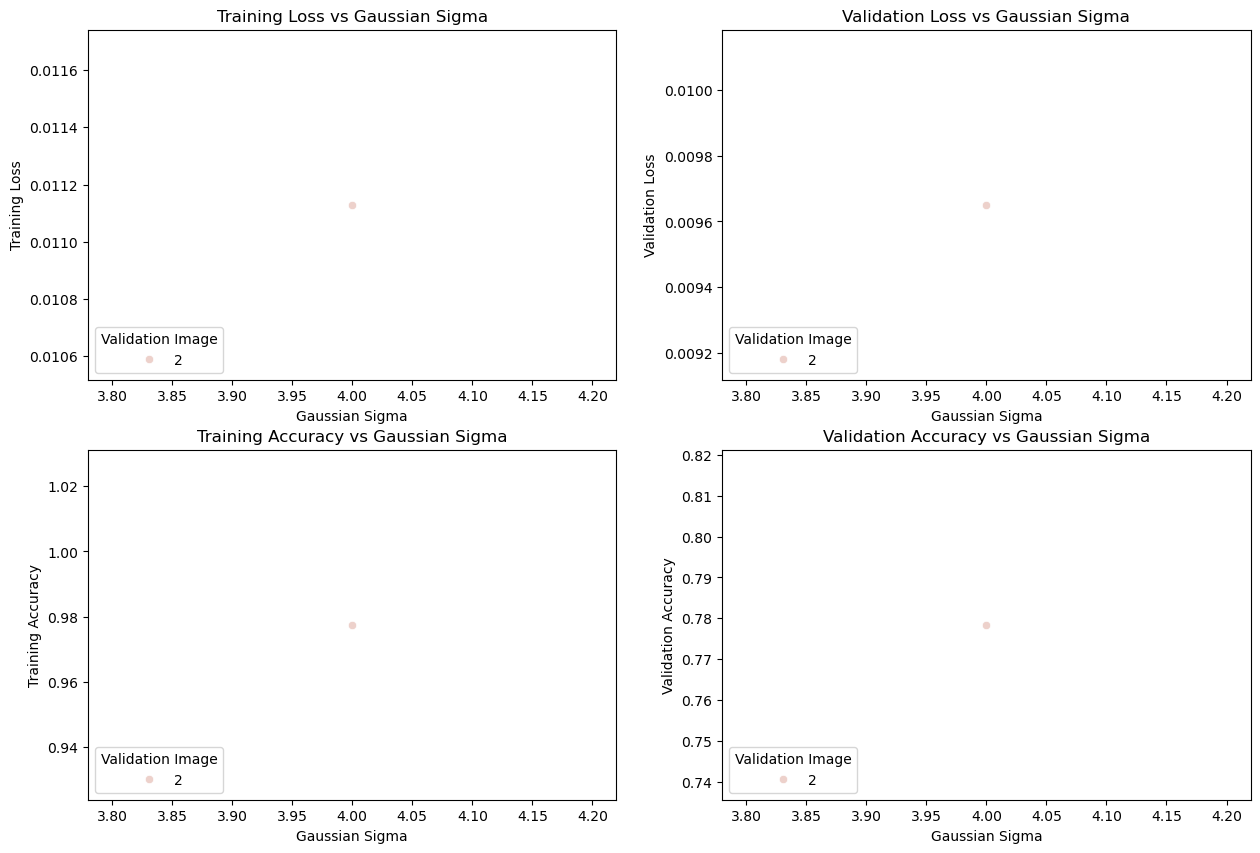

In [6]:

if not DRAFT:
  results.to_csv('results.csv', index=False, sep=';')
  R = pd.read_csv('results.csv', sep=';', converters=dict(ti=ast.literal_eval, vi=ast.literal_eval)).rename(columns=dict(vi=key2text['vi']))
  plot.regplot(R, P, key2text)

results